# ANOVA analysis

Analysis of Variance (a.k.a. multi-way ANOVA) is a statistical test that
examines the importance of multiple independent variables (e.g., two or
more software metrics) on the outcome (e.g.,
defect-proneness) {cite}`fisher1925intraclass`. The significance of each
metric in a regression model is estimated from the calculation of the
Sum of Squares (SS)---i.e., the explained variance of the observations
with respect to their mean value. There are two commonly-used approaches
to calculate the Sum of Squares for ANOVA, namely, Type-I and Type-II.
We provide a description of the two types of ANOVA below.

**Type-I**, *one of the most commonly-used interpretation techniques and
the default interpretation technique for a logistic regression (`glm`)
model in R*, examines the importance of each metric in a sequential
order {cite}`fox2015applied`{cite}`chambers1992statistical`. In other words,
Type-I measures the improvement of the Residual Sum of Squares (RSS)
(i.e., the unexplained variance) when each metric is sequentially added
into the model. Hence, Type-I attributes as much variance as it can to
the first metric before attributing residual variance to the second
metric in the model specification. Thus, the importance (i.e., produced
ranking) of metrics is dependent on the ordering of metrics in the model
specification.

The calculation starts from the RSS of the preliminary model
($y \sim 1$), i.e., a null model that is fitted without any software
metrics. We then compute the RSS of the first metric by fitting a
regression model with the first metric ($y \sim m_1$). Thus, the
importance of the first metric ($m_1$) is the improvement between the
unexplained variances (RSS) of the preliminary model and the model that
is constructed by the first metric.

$$\mathrm{SS}(m_1) = \mathrm{RSS}(\mathrm{Model}_\mathrm{null})-\mathrm{RSS}(m_1)$$

Similar to the computation of the importance of the first metric, the
importance of the remaining metrics is computed using the following
equation.

$$\mathrm{SS}(m_i) = \mathrm{RSS}(\mathrm{m_1 + ... + m_{i-1}})-\mathrm{RSS}(m_1 + ... + m_i)$$

**Type II**, an enhancement to the ANOVA Type-I, examines the importance
of each metric in a hierarchical nature, i.e., the ordering of metrics
is rearranged for each
examination {cite}`fox2015applied`{cite}`chambers1992statistical`. The importance
of metrics (Type-II) measures the improvement of the Residual Sum of
Squares (RSS) (i.e., the unexplained variance) when adding a metric
under examination to the model after the other metrics. In other words,
the importance of metrics (Type-II) is equivalent to a Type-I where a
metric under examination appears at the last position of the model. The
intuition is that the Type-II is evaluated after all of the other
metrics have been accounted for. The importance of each metric (i.e.,
SS($m_e$)) measures the improvement of the RSS of the model that is
constructed by adding only the other metrics except for the metric under
examination, and the RSS of the model that is constructed by adding the
other metrics where the metric under examination appears at the last
position of the model. For example, given a set of $M$ metrics, and
$e,i,j\in[1,M]$, the importance of each metric $m_e$ can be explained as
follows:

$$\mathrm{SS}(m_e) = \mathrm{RSS}(m_i + ... + m_{j})-\mathrm{RSS}(m_i + ... + m_{j} + m_e)$$

where $m_e$ is the metric under examination and $m_i + ... + m_{j}$ is a
set of the other metrics except the metric under examination.

## Tutorial

### Load Data and preparing datasets

In [1]:
# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd
# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

train_dataset = pd.read_csv(("../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

### Construct a black-box model (Regression and Random Forests)

In [2]:
# Import for Construct a black-box model (Regression and Random Forests)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# regression (ols)
model_formula = outcome + ' ~ ' + ' + '.join(features)
regression_model = ols(model_formula, data = training_data)
# regression_model = sm.OLS(y_train, sm.add_constant(X_train))
regression_model_fit = regression_model.fit()

# regression (logistic regression)
lr_model = LogisticRegression(fit_intercept = True)
lr_model.fit(X_train, y_train)  

# random forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rf_model.fit(X_train, y_train)  

RandomForestClassifier(n_jobs=10, random_state=1234)

### Cross-release model validation for sanity check (Train with 2.9.0 and test with 3.0.0)

In [3]:
from sklearn import metrics

In [4]:
def get_model_performance(model, X_test, y_test):
    model_prediction = model.predict_proba(X_test.values)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_prediction, pos_label=1)
    auc_value = metrics.auc(fpr, tpr)
    transformed_prediction = [int(i >= 0.5) for i in model_prediction]
    f1_value = metrics.f1_score(y_test, transformed_prediction)
    return auc_value, f1_value

In [5]:
print('Regression (AUC, F1):', get_model_performance(lr_model, X_test, y_test))
print('Random Forests (AUC, F1):', get_model_performance(rf_model, X_test, y_test))

Regression (AUC, F1): (0.7989602095955461, 0.23236514522821577)
Random Forests (AUC, F1): (0.8589023524916761, 0.4951456310679611)


## Model Explanation

### ANOVA (Regression)

In [6]:
# Import for ANOVA (Regression)
import statsmodels.api as sm

In [7]:
# compute an ANOVA Type-II table
aov_table = sm.stats.anova_lm(regression_model_fit, 
                              typ=2)
aov_table.sort_values(by = 'sum_sq', ascending = False, inplace = True)

<AxesSubplot:ylabel='Features'>

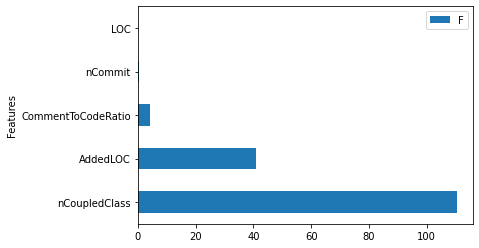

In [8]:
# visualize an ANOVA Type-II table
aov_table['Features'] = aov_table.index
aov_table.iloc[1:,:].plot(kind = 'barh', y = 'F', x = 'Features') # remove the residual